In [64]:
import pandas as pd
import numpy as np

Creating an array of the column names 

In [65]:
names = ['id', 'id_str','screen_name', 'location', 'description', 'url', 'followers_count', 'friends_count', 'listedcount','created_at','favourites_count','verified','statuses_count','lang','status','default_profile','default_profile_image','has_extended_profile','name','bot']

Reading the bots and non bots data from the CSV files and combining them into one dataframe

In [66]:
df_bots = pd.read_csv('bots_data.csv',header=None,names=names,na_values='?',skiprows=1)
df_nonbots = pd.read_csv('nonbots_data.csv',header=None,names=names,na_values='?',skiprows=1)
frames = [df_bots, df_nonbots]
df = pd.concat(frames)

The codes that follow are used to extract certain features from the raw data obtained from the csv files.

The first feature that we are computing is the screen name length from the screen name column in the data

In [67]:
screen = list(df['screen_name'])
screen_length = []
for i in screen:
    screen_length.append(len(i))
df['screen_length'] = screen_length

The second feature we are computing is the profile name length from the name colum in the data 

In [68]:
names = list(df['name'])
name_length = []
for i in names:
    name_length.append(len(i))
df['name_length'] = name_length

The third feature we are computing is the days since the account was created. We do this by creating a datetime 
object from the dates present in the created at column. The data contains various formats of data thus we need to
handle each seperately.

In [69]:
created_at = list(df['created_at'])
dates = list(df['created_at'])
number_days =[]
from datetime import datetime

datetime_object = datetime.strptime('Jun 1 2005  1:33PM', '%b %d %Y %I:%M%p')

for i in dates:
    if i[0] == '"':
        i = i[1:-1]
    if i[-1] == '"':
        i = i[:-1]
    now = datetime.now()
    a = str(i.split(" ")[0])
    s1 = ""
    #print a
    if(a.find('/',0,len(a))==-1):
        #s1.append(a.split(' ')[1],a.split(' ')[2],a.split(' '))
        d1 = datetime.strptime(i,'%a %b %d %H:%M:%S +0000 %Y')
        delta = now - d1
        #print delta.days
        number_days.append(delta.days)
    else:
        try:
            d2 = datetime.strptime(i,'%d/%m/%Y %H:%M')
            delta = now - d2
            #print delta.days
        except ValueError:
            d2 = datetime.strptime(i,'%m/%d/%Y %H:%M')
            delta = now - d2
            #print delta.days
        number_days.append(delta.days)
#print number_days
    #print i
df['number_days'] = number_days

The fourth feature we are computing is whether the account description contains the term "bot" in it. We store a value 
1 if the description contains the term bot and 0 otherwise

In [70]:
desc = df['description']
flag = []
for i in desc:
    i = str(i)
    #print i
    if i.find("bot")==-1:
        #print 0
        flag.append(0)
    else:
        #print 1
        flag.append(1)
df['desc_contains_bot']=flag

The final dataframe we create has all the features that we will use in the classification model. The schema of this dataframe is as follows 

In [71]:
final = df[['followers_count','friends_count','listedcount','favourites_count','verified','statuses_count','default_profile','default_profile_image','has_extended_profile','screen_length','name_length','number_days','desc_contains_bot','bot']]
final.dtypes

followers_count           int64
friends_count             int64
listedcount               int64
favourites_count          int64
verified                   bool
statuses_count            int64
default_profile            bool
default_profile_image      bool
has_extended_profile     object
screen_length             int64
name_length               int64
number_days               int64
desc_contains_bot         int64
bot                       int64
dtype: object

From this dataframe we create the training (80%) and the testing (20%) sets.

In [73]:
final= final.dropna()
y = final['bot']
X = final[['followers_count','friends_count','listedcount','favourites_count','verified','statuses_count','default_profile','default_profile_image','has_extended_profile','screen_length','name_length','number_days','desc_contains_bot']]

from sklearn.model_selection import train_test_split
train_features, test_features, train_label, test_label = train_test_split( X, y, test_size=0.2)

The first classification model we are using is the Decision Tree Classifier. The accuracy of this model is also displayed. 

In [112]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(min_samples_split=10, criterion='entropy', max_depth= 6)
clf.fit(train_features, train_label)
pred = clf.predict(test_features)
from sklearn.metrics import accuracy_score
print accuracy_score(test_label,lpred)

0.893271461717


We plot the roc curve of this model using the metrics module from sklearn

('Precision Score: ', 0.89330139311577827)


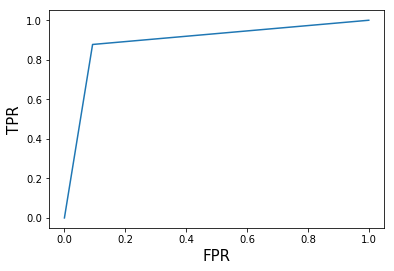

In [113]:
from sklearn import metrics
from sklearn.metrics import precision_score
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fpr, tpr, thresholds = metrics.roc_curve(test_label, pred,pos_label=1)
metrics.auc(fpr,tpr)
plt.xlabel('FPR',fontsize=15)
plt.ylabel('TPR',fontsize=15)
plt.plot(fpr,tpr)

print("Precision Score: ", (precision_score(test_label,pred,average='weighted' )))

One of the methods to improve the accuracy of the model is by using cross validation. Here we implement a 5 fold cross validation on the model and display the accuracy, precision and recall of the model

In [117]:
from sklearn.metrics import accuracy_score
print accuracy_score(test_label,pred)
from sklearn.model_selection import cross_val_score
accuracy_scores = cross_val_score(clf, X, y, cv=5)
print accuracy_scores
print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() * 2))
precision = cross_val_score(clf, X, y, cv=5, scoring='precision')
print("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf, X, y, cv=5, scoring='recall')
print("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))

from sklearn.metrics import confusion_matrix
confusion_matrix(test_label, pred)

0.893271461717
[ 0.87962963  0.89791183  0.90719258  0.90465116  0.88139535]
Accuracy: 0.89 (+/- 0.02)
Precision: 0.88 (+/- 0.04)
Recall: 0.89 (+/- 0.03)


array([[206,  21],
       [ 25, 179]])

Here we display the classification report using sklearn metrics

In [119]:
from sklearn.metrics import classification_report
target_names = ['Bot', 'Not Bot']
print(classification_report(test_label, pred, target_names=target_names))

             precision    recall  f1-score   support

        Bot       0.89      0.91      0.90       227
    Not Bot       0.90      0.88      0.89       204

avg / total       0.89      0.89      0.89       431



Here we plot the relative importance of the features as used by the model.

[ 0.02543221  0.1616164   0.02640837  0.06723423  0.05098168  0.07556157
  0.          0.          0.          0.          0.00302352  0.58665002
  0.00309201]


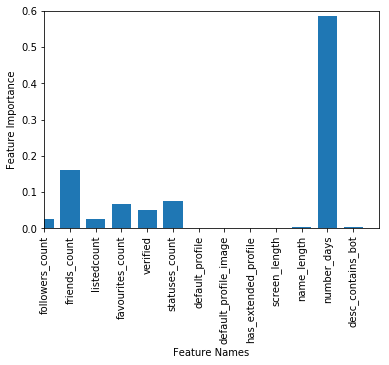

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline
col_names = ['followers_count','friends_count','listedcount','favourites_count','verified','statuses_count','default_profile','default_profile_image','has_extended_profile','screen_length','name_length','number_days','desc_contains_bot']

a = [i for i,_ in enumerate(col_names[:])]
b = clf.feature_importances_
print b

plt.axis([0,13,0,.6])
plt.bar(a, b,width = .75)
plt.xticks(a,col_names[:],rotation = 90)
plt.xlabel('Feature Names') 
plt.ylabel('Feature Importance')

Here we are trying to gauge which parameters of the model give us the best results in terms of accuracy. We used grid search method from sklearn to do this. By specifying the range of parameters of the model grid search creates all permutations of parameters for this model and returns us the set of parameters which give the best results.

In [116]:
from sklearn import grid_search
parameters = {'max_depth': range(1,30,1),
'min_samples_split' : range(10,500,10),
'criterion': ('entropy','gini')}
from sklearn import tree
tree = tree.DecisionTreeClassifier()
clf = grid_search.GridSearchCV(tree, parameters)
clf.fit(train_features, train_label)
print clf.best_params_

{'min_samples_split': 10, 'criterion': 'gini', 'max_depth': 7}


The second classifier that we are using is Random Forest. We use sklearn to implement this model 
and display the accuracy.

In [120]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=700)
clf.fit(train_features, train_label)
pred = clf.predict(test_features)
from sklearn.metrics import accuracy_score
print accuracy_score(test_label,pred)

0.916473317865


Here we display the classification report using sklearn metrics

In [121]:
from sklearn.metrics import classification_report
target_names = ['Bot', 'Not Bot']
print(classification_report(test_label, pred, target_names=target_names))

             precision    recall  f1-score   support

        Bot       0.91      0.93      0.92       227
    Not Bot       0.92      0.90      0.91       204

avg / total       0.92      0.92      0.92       431



We plot the roc curve of this model using the metrics module from sklearn

('Precision Score: ', 0.90259459025120292)


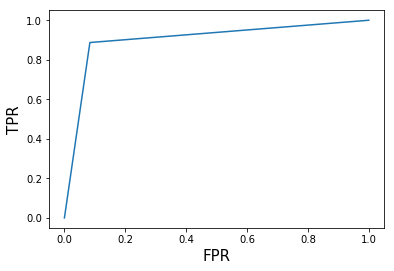

In [100]:
from sklearn import metrics
from sklearn.metrics import precision_score
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fpr, tpr, thresholds = metrics.roc_curve(test_label, pred,pos_label=1)
metrics.auc(fpr,tpr)
plt.xlabel('FPR',fontsize=15)
plt.ylabel('TPR',fontsize=15)
plt.plot(fpr,tpr)

print("Precision Score: ", (precision_score(test_label,pred,average='weighted' )))

One of the methods to improve the accuracy of the model is by using cross validation. Here we implement a 5 fold cross validation on the model and display the accuracy, precision and recall of the model

In [90]:
from sklearn.metrics import accuracy_score
print accuracy_score(test_label,pred)
from sklearn.model_selection import cross_val_score
accuracy_scores = cross_val_score(clf, X, y, cv=5)
print accuracy_scores
print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() * 2))
precision = cross_val_score(clf, X, y, cv=5, scoring='precision')
print("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf, X, y, cv=5, scoring='recall')
print("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))

0.91879350348
[ 0.90046296  0.89791183  0.93735499  0.90232558  0.93488372]
Accuracy: 0.91 (+/- 0.04)
Precision: 0.91 (+/- 0.04)
Recall: 0.91 (+/- 0.05)


Here we plot the relative importance of the features as used by the model.

[ 0.09358618  0.15959749  0.06420263  0.10790414  0.07183277  0.07544089
  0.02661347  0.00253549  0.01418594  0.02401358  0.02931617  0.30693762
  0.02383363]


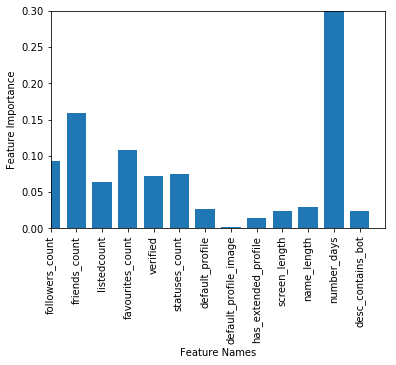

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline
col_names = ['followers_count','friends_count','listedcount','favourites_count','verified','statuses_count','default_profile','default_profile_image','has_extended_profile','screen_length','name_length','number_days','desc_contains_bot']

a = [i for i,_ in enumerate(col_names[:])]
b = clf.feature_importances_
print b

plt.axis([0,13,0,.3])
plt.bar(a, b,width = .75)
plt.xticks(a,col_names[:],rotation = 90)
plt.xlabel('Feature Names') 
plt.ylabel('Feature Importance')

Here we are trying to gauge which parameters of the model give us the best results in terms of accuracy. We used grid search method from sklearn to do this. By specifying the range of parameters of the model grid search creates all permutations of parameters for this model and returns us the set of parameters which give the best results

In [34]:
param_grid = {'max_depth' : [None, 10,20,30,40,50],
              'n_estimators' :[100,200,300,400,500,600,700,800,900,1000]}
from sklearn import grid_search
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
clf = grid_search.GridSearchCV(forest, param_grid)
clf.fit(train_features, train_label)
print clf.best_params_

{'max_features': 'auto', 'n_estimators': 700, 'max_depth': None}


The rest of the code contains different models that we tried to use for classification. Some of them give good results and we may use them for the final phase of project. Some of them do not give us good results based on the set of features we selected. 

In [35]:
# For future implementation 
# We may consider using this algorithm for the final phase of the project
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100)
clf.fit(train_features, train_label)
pred = clf.predict(test_features)
from sklearn.metrics import accuracy_score
print accuracy_score(test_label,pred)

0.916473317865


[ 0.11  0.23  0.11  0.08  0.02  0.2   0.    0.    0.02  0.01  0.03  0.16
  0.03]


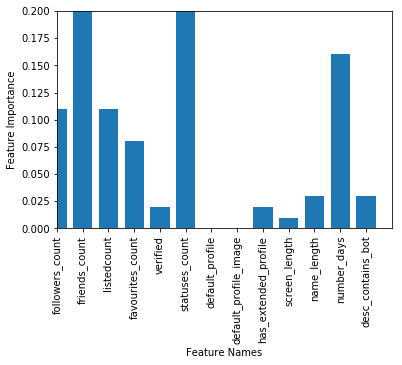

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
col_names = ['followers_count','friends_count','listedcount','favourites_count','verified','statuses_count','default_profile','default_profile_image','has_extended_profile','screen_length','name_length','number_days','desc_contains_bot']

a = [i for i,_ in enumerate(col_names[:])]
b = clf.feature_importances_
print b

plt.axis([0,13,0,.2])
plt.bar(a, b,width = .75)
plt.xticks(a,col_names[:],rotation = 90)
plt.xlabel('Feature Names') 
plt.ylabel('Feature Importance')

In [37]:
# Inefficient Algorithms - 
#Implemetation of algorithms that did not give us satisfactory accuracy using our set of features from sklearn import linear_model, datasets
#logreg = linear_model.LogisticRegression(C=1e5)
#logreg.fit(train_features, train_label)
#pred = logreg.predict(test_features)
#from sklearn.metrics import accuracy_score
#print accuracy_score(test_label,pred)

0.60788863109


In [38]:
# Inefficient Algorithms - 
#Implemetation of algorithms that did not give us satisfactory accuracy using our set of features 
#from sklearn.neural_network import MLPClassifier
#clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
#clf.fit(train_features, train_label)
#pred = clf.predict(test_features)
#from sklearn.metrics import accuracy_score
#print accuracy_score(test_label,pred)

0.735498839907


In [60]:
# Inefficient Algorithms - 
#Implemetation of algorithms that did not give us satisfactory accuracy using our set of features 
#from sklearn import svm
#clf = svm.SVC()
#clf.fit(train_features, train_label)
#pred = clf.predict(test_features)
#from sklearn.metrics import accuracy_score
#print accuracy_score(test_label,pred)

In [61]:
# Inefficient Algorithms - 
#Implemetation of algorithms that did not give us satisfactory accuracy using our set of features 
#from sklearn.naive_bayes import BernoulliNB
#clf = BernoulliNB()
#clf.fit(train_features, train_label)
#pred = clf.predict(test_features)
#from sklearn.metrics import accuracy_score
#print accuracy_score(test_label,pred